# CNN

In [5]:
torch.__version__

'1.7.1+cu101'

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.set_device(0)

In [8]:
gramian_df = pd.read_csv('../data/gramian_df.csv', index_col='date')

In [9]:
path = '../data/'
df = pd.read_csv(path+'/label_dir_2.csv')
df = df[df.date.isin(list(gramian_df.index))]
df.date = df.date.apply(lambda x: x+'.png')
df.head()

,date,label
0,2017-01-02.png,0
1,2017-01-03.png,1
2,2017-01-04.png,0
3,2017-01-05.png,1
4,2017-01-06.png,0


In [10]:
df.groupby('label').date.count()

label
0    531
1    457
Name: date, dtype: int64

In [11]:
data = ImageDataBunch.from_df(path, df, valid_pct=0.2, size=224)

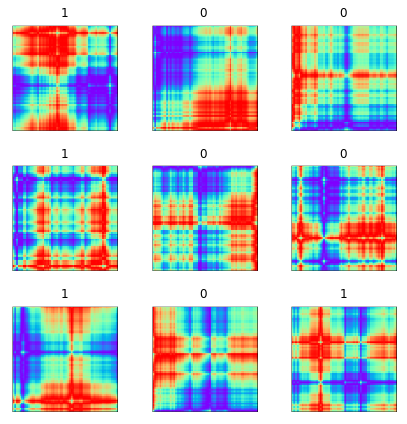

In [12]:
data.show_batch(rows=3, figsize=(6,6))

### 1. Base CNN (ResNet34 + Custom Head)

In [13]:
# Create custom_head
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,2)]
head = nn.Sequential(*layers)

In [14]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True,
                      custom_head=head,
#                       loss_func=mae,
                     metrics=[error_rate, accuracy]
#                       metrics=[acc_02, f_score]
                     ).to_fp16()
#learner = cnn_learner(data, models.resnet34, pretrained = True, custom_head=head, loss_func=mae, metrics=[r2_score]).to_fp16()
learner.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Linear(in_features=1024, out_features=2, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.22E-04
Min loss divided by 10: 3.03E-03


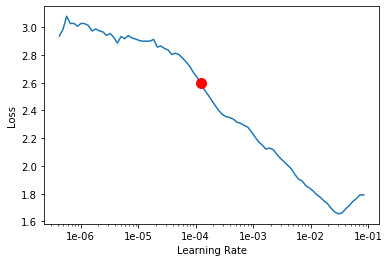

In [15]:
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100)
learner.recorder.plot(suggestion=True)

In [16]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.00012232203508681874


In [17]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.827903,1.383633,0.517766,0.482233,00:11
1,2.398217,1.564071,0.507614,0.492386,00:10
2,1.925474,1.221436,0.456853,0.543147,00:11
3,1.668029,1.177765,0.431472,0.568528,00:11
4,1.475420,1.216013,0.421320,0.578680,00:11
5,1.334943,1.226529,0.395939,0.604061,00:11
6,1.213631,1.223605,0.395939,0.604061,00:12
7,1.118495,1.229684,0.401015,0.598985,00:11
8,1.041904,1.227265,0.401015,0.598985,00:11
9,0.989985,1.227929,0.401015,0.598985,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.87E-05
Min loss divided by 10: 1.25E-04


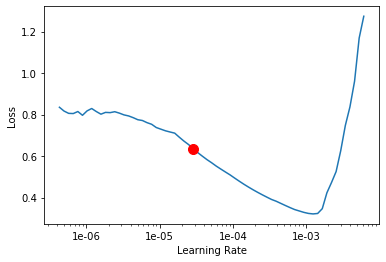

In [18]:
learner.unfreeze()
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [19]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

2.866828401237955e-05


In [20]:
learner.fit_one_cycle(10, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.815758,1.226187,0.401015,0.598985,00:12
1,0.739439,1.187481,0.390863,0.609137,00:12
2,0.589798,1.151651,0.390863,0.609137,00:12
3,0.441224,1.132998,0.401015,0.598985,00:12
4,0.330563,1.129507,0.390863,0.609137,00:13
5,0.251800,1.124074,0.380711,0.619289,00:13
6,0.196288,1.124998,0.380711,0.619289,00:13
7,0.155583,1.126130,0.385787,0.614213,00:13
8,0.125773,1.129060,0.390863,0.609137,00:13
9,0.104037,1.125402,0.380711,0.619289,00:12


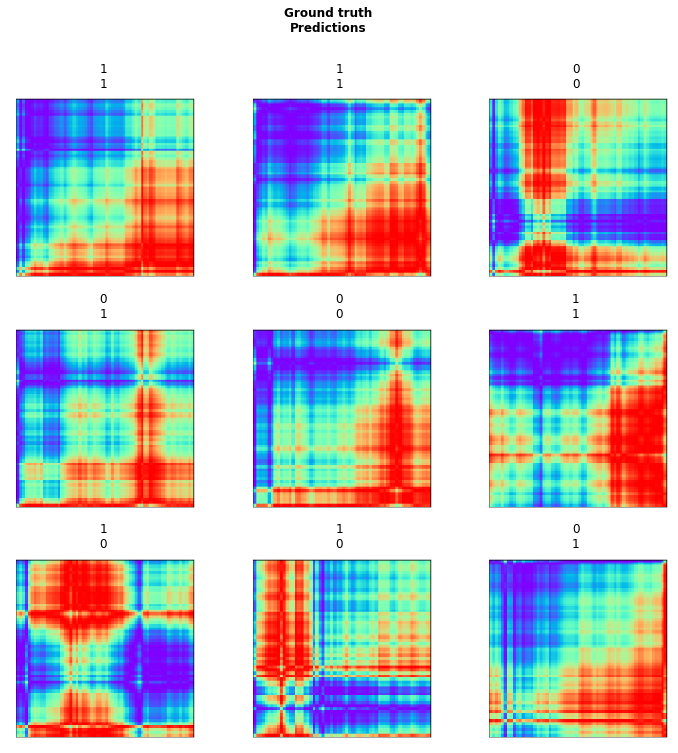

In [21]:
learner.show_results(rows=3)

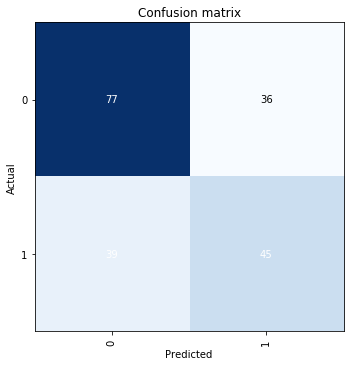

In [22]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(5,5))

In [23]:
learner.save('model_1')

## Grad-CAM

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from importlib import reload

In [74]:
import gradcam
reload(gradcam)
from gradcam import *

In [27]:
test_img = '../data/imgs/2017-01-03.png'
img = open_image(test_img);

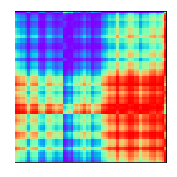

In [9]:
img.show()

In [8]:
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,2)]
head = nn.Sequential(*layers)

gramian_df = pd.read_csv('../data/gramian_df.csv',index_col='date')
path = '../data/'
df = pd.read_csv(path+'/label_dir_2.csv')
df = df[df.date.isin(list(gramian_df.index))]
df.date = df.date.apply(lambda x: x+'.png')
data = ImageDataBunch.from_df(path, df, valid_pct=0.2, size=224)

learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True,
                      custom_head=head,
                     metrics=[error_rate, accuracy]
                     ).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [56]:
learner.load('model_1');

In [1]:
# gcam = GradCam.from_one_img(learner,img)
# gcam.plot()